# Text to Image pipeline and OpenVINO with Generate API

[OpenVINO™ GenAI](https://github.com/openvinotoolkit/openvino.genai) is a library of the most popular Generative AI model pipelines, optimized execution methods, and samples that run on top of highly performant OpenVINO Runtime.

This library is friendly to PC and laptop execution, and optimized for resource consumption. It requires no external dependencies to run generative models as it already includes all the core functionality (e.g. tokenization via openvino-tokenizers).

In this notebook we will demonstrate how to use text to image models like Stable Diffusion 1.5, 2.1, LCM using [Dreamlike Anime 1.0](https://huggingface.co/dreamlike-art/dreamlike-anime-1.0) as an example. All it takes is two steps: 
1. Export OpenVINO IR format model using the [Hugging Face Optimum](https://huggingface.co/docs/optimum/installation) library accelerated by OpenVINO integration.
The Hugging Face Optimum Intel API is a high-level API that enables us to convert and quantize models from the Hugging Face Transformers library to the OpenVINO™ IR format. For more details, refer to the [Hugging Face Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/inference).
2. Run inference using the [Text-to-Image Generation pipeline](https://docs.openvino.ai/2024/learn-openvino/llm_inference_guide/genai-guide.html) from OpenVINO GenAI.



#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert model using Optimum-CLI tool](#Convert-model-using-Optimum-CLI-tool)
- [Run inference OpenVINO model with Text2ImagePipeline](#Run-inference-OpenVINO-model-with-Text2ImagePipeline)
- [Run inference OpenVINO model with Text2ImagePipeline with optional LoRA adapters](#Run-inference-OpenVINO-model-with-Text2ImagePipeline-with-optional-LoRA-adapters)
- [Interactive demo](#Interactive-demo)

### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/text-to-image-genai/text-to-image-genai.ipynb" />

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import platform
import requests


%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -q -U --pre --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly "openvino>=2024.5" "openvino-tokenizers>=2024.5" "openvino-genai>=2024.5"
%pip install -q Pillow "diffusers>=0.30.3" "gradio>=4.19" "typing_extensions>=4.9" "tqdm"
if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
)
open("cmd_helper.py", "w").write(r.text)

## Convert model using Optimum-CLI tool
[back to top ⬆️](#Table-of-contents:)

🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 [Transformers](https://huggingface.co/docs/transformers/index) and [Diffusers](https://huggingface.co/docs/diffusers/index) libraries and OpenVINO to accelerate end-to-end pipelines on Intel architectures. It provides ease-to-use cli interface for exporting models to [OpenVINO Intermediate Representation (IR)](https://docs.openvino.ai/2024/documentation/openvino-ir-format.html) format.

The command bellow demonstrates basic command for model export with `optimum-cli`

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <out_dir>
```

where `--model` argument is model id from HuggingFace Hub or local directory with model (saved using `.save_pretrained` method), `--task ` is one of [supported task](https://huggingface.co/docs/optimum/exporters/task_manager) that exported model should solve. For image generation models, `text-to-image` should be used. If model initialization requires to use remote code, `--trust-remote-code` flag additionally should be passed.
You can also apply fp16, 8-bit or 4-bit weight compression on the Linear, Convolutional and Embedding layers when exporting your model with the CLI by setting `--weight-format` to respectively fp16, int8 or int4. This type of optimization allows to reduce the memory footprint and inference latency.

We will use `optimum_cli` from our helper `cmd_helper.py` that is a wrapper over cli-command.

In [2]:
from pathlib import Path

from cmd_helper import optimum_cli


model_dir = Path("dreamlike_anime_1_0_ov")

if not model_dir.exists():
    optimum_cli("dreamlike-art/dreamlike-anime-1.0", model_dir)

## Run inference OpenVINO model with Text2ImagePipeline
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [3]:
from notebook_utils import device_widget


device = device_widget("CPU", exclude=["NPU"])
device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

And now just provide `model_dir` and the chosen inference device to `openvino_genai.Text2ImagePipeline` and call `generate` method for inference. For results reproducibility we will use `ov_genai.TorchGenerator`, pseudo-random numbers generator, which behavior aligned with PyTorch Generator. That's it:) 

In [4]:
import openvino_genai as ov_genai
from PIL import Image
from tqdm.notebook import tqdm
import sys

num_inference_steps = 20

random_generator = ov_genai.TorchGenerator(42)

pipe = ov_genai.Text2ImagePipeline(model_dir, device.value)
prompt = "cyberpunk cityscape like Tokyo New York with tall buildings at dusk golden hour cinematic lighting"

pbar = tqdm(total=num_inference_steps)


def callback(step, num_steps, latent):
    pbar.update(1)
    sys.stdout.flush()
    return False


image_tensor = pipe.generate(prompt, width=512, height=512, num_inference_steps=20, num_images_per_prompt=1, generator=random_generator, callback=callback)

pbar.close()

image = Image.fromarray(image_tensor.data[0])

  0%|          | 0/20 [00:00<?, ?it/s]

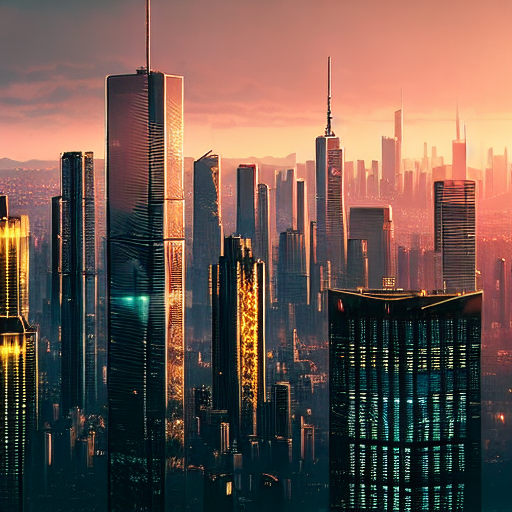

In [5]:
image

## Run inference OpenVINO model with Text2ImagePipeline with optional LoRA adapters
[back to top ⬆️](#Table-of-contents:)

LoRA adapters can be connected to the pipeline and modify generated images to have certain style, details or quality. Adapters are supported in `Safetensors` format and can be downloaded from public sources like [Civitai](https://civitai.com) or [HuggingFace](https://huggingface.co/models) or trained by the user. Adapters compatible with a base model should be used only. A weighted blend of multiple adapters can be applied by specifying multiple adapter files with corresponding alpha parameters in command line. Check `lora.cpp` source code to learn how to enable adapters and specify them in each `generate` call.

Here is an example how to run the sample with a single adapter. First download adapter file from https://civitai.com/models/67927/soulcard page manually and save it as `soulcard.safetensors`. Or download it from command line:

In [6]:
if not Path("soulcard.safetensors").exists():
    r = requests.get(
        url="https://civitai.com/api/download/models/72591",
    )
    with open("soulcard.safetensors", "wb") as file:
        file.write(r.content)

In [7]:
def prepare_adapter_config(adapters):
    adapter_config = ov_genai.AdapterConfig()

    # Multiple LoRA adapters applied simultaneously are supported, parse them all and corresponding alphas from cmd parameters:
    for i in range(int(len(adapters) / 2)):
        adapter = ov_genai.Adapter(adapters[2 * i])
        alpha = float(adapters[2 * i + 1])
        adapter_config.add(adapter, alpha)

    return adapter_config


adapter_config = prepare_adapter_config(["soulcard.safetensors", 0.5])

pipe = ov_genai.Text2ImagePipeline(model_dir, device.value, adapters=adapter_config)

pbar = tqdm(total=num_inference_steps)

image_tensor = pipe.generate(prompt, generator=ov_genai.TorchGenerator(42), width=512, height=512, num_inference_steps=20, callback=callback)
image = Image.fromarray(image_tensor.data[0])
pbar.close()

  0%|          | 0/20 [00:00<?, ?it/s]

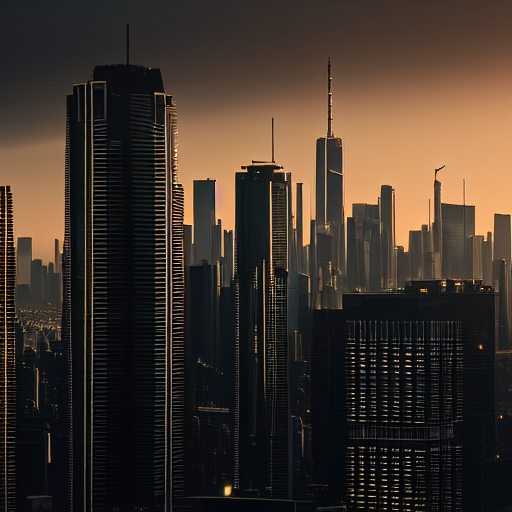

In [8]:
image

You can find more detailed tutorial for running inference with multiple LoRA adapters in this [notebook](../multilora-image-generation/multilora-image-generation.ipynb)

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo


demo = make_demo(pipe, ov_genai.TorchGenerator, adapter_config)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/